In [50]:
import numpy as np

from scipy.optimize import curve_fit
from scipy.io import loadmat
from ImageProcessing import *

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

from ImageProcessing import *
from ImageGenerator import ImageGenerator
from ImageClassifier import *

from sklearn.mixture import GaussianMixture

# Loading Data

In [2]:
data = loadmat('jun1_run9.mat')
n_loops = 20
lattice_shape = np.array([10, 10])
stack = data['stack']

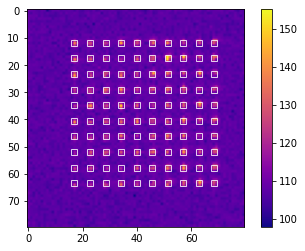

In [3]:
processor = GreenImageProcessor(stack, lattice_shape, 20)
processor.plot()

In [72]:
crops = processor.crop_sites(1)
crop = np.mean(crops[0], axis=(2,3)).flatten()
counts, bins = np.histogram(crop, bins=(processor.per_loop // 4))
centers = (bins[:-1] + bins[1:]) / 2

In [93]:
tot = np.sum(crop)
mix = GaussianMixture(2)
mix.fit(np.reshape(crop, (crop.shape[0], 1)))
means = mix.means_.flatten()
weights = mix.weights_.flatten()
std = np.sqrt(mix.covariances_.flatten())
print(tot)

297695.6111111111


[0.00074013 0.00222039 0.00592105 0.01036184 0.01776316 0.02664474
 0.06143092 0.08881579 0.13026316 0.17541118 0.18207237 0.16060855
 0.0984375  0.06291118 0.03256579 0.02738487 0.02590461 0.03182566
 0.04736842 0.07697368 0.08881579 0.12286184 0.11472039 0.11324013
 0.09029605 0.08141447 0.05699013 0.03478618 0.02368421 0.01110197
 0.00370066 0.00296053 0.00074013 0.00222039]


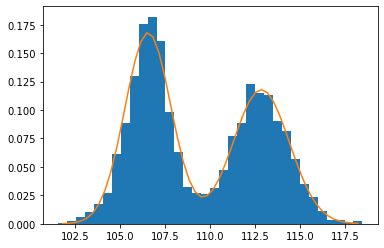

In [95]:
counts, bins, _ = plt.hist(crop, bins=(processor.per_loop // 4), density=True)
x = np.linspace(centers[0], centers[-1])
print(counts)
#print(weights)
#print(gaussian(x, means[0], std[0], weights[0]))
plt.plot(x, 0.398942280401 * (gaussian(x, means[0], std[0], weights[0]) / std[0] + gaussian(x, means[1], std[1], weights[1] / std[1])))